# cityD SVR
ver10:シンプルSVRを作成した。
ver20:ここで、越智さんがしてた学習データの欠損埋めを行ってからSVRを適用してみる。  
ver30:クラスタリングのタイプ別をいれてみる
ver40:移動系の特徴量もいれてみる

#### 設定

In [1]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

Cloning into 'geobleu'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 156 (delta 75), reused 126 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 26.72 KiB | 2.97 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.3-py3-none-any.whl size=5037 sha256=502045ce0b874827faca891864f153383596ea2c9dac55a01117ad8fad5e0676
  Stored in directory: /tmp/pip-ephem-wheel-cache-_x7y37m0/wheels/90/15/a1/d49421f5100216d00a75ab920989107243909c099af9364987
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [2]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
INPUT_PATH = "../../../s3storage/01_public/humob-challenge-2024/input/cityD_challengedata.csv.gz"
# INPUT_PATH = "/kaggle/input/humob2024/cityB_challengedata.csv/hiroshima_challengedata.csv"

#### データ読み込み

In [8]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head()

,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98
2,0,0,16,162,99
3,0,0,17,149,97
4,0,0,18,144,98


#### ユーザーを絞り込み、d=60前後で訓練データと正解データに分割

In [9]:
# uidが20000~21999のデータを検証に利用
df_city_b_valid = (
    df_city_b
    .loc[df_city_b["uid"].between(3000, 6000)]
    # .loc[df_city_b["uid"].between(20000, 20100)]

)
df_city_b_valid.head(3)

,uid,d,t,x,y
4352478,3000,7,25,192,24
4352479,3000,7,41,193,23
4352480,3000,7,42,192,24


In [11]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] < 60]
)

df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] >= 60]
)

In [13]:
def get_full_df(df, d_range, t_range):
    """
    input: uid, d, t, x, yのdf
    output: 全uidでd×tを揃えたdfを作成。x, yが欠損値の場合はnull。
    """
    # 全てのd, tの範囲のデータフレームを作成
    full_range_d = pd.DataFrame({'d': range(0, d_range)})
    full_range_t = pd.DataFrame({'t': range(0, t_range)})

    # uidのユニークな値を取得し、クロス結合を行う
    full_range_uid = pd.DataFrame({'uid': df['uid'].unique()})

    # クロス結合を行う（全てのuid, d, tの組み合わせ）
    full_range = (full_range_uid.assign(key=1)
                  .merge(full_range_d.assign(key=1), on='key')
                  .merge(full_range_t.assign(key=1), on='key')
                  .drop('key', axis=1)
                 )

    # x, yの値を付与し、欠損値はnullとする
    df_train_full = (full_range
                     .merge(df, on=['uid', 'd', 't'], how='left')
                     .sort_values(by=['uid', 'd', 't'])
                    )

    return df_train_full

In [14]:
def interpolate_missing_values(df,N):
    """
    input: uid, d, t, x, yのdf、uidにつきd×tは60×48、x, y欠損値はnull
    output: 3時間未満の連続するx, y欠損を直近の前後のx, y値を用いて線形補完したdf
    """
    df_fill = df.fillna(-1).copy()  # 欠損値を一時的に -1 に変換
    skip_list = []
    interpolate_num = 0
    
    for i in range(len(df_fill)):
#     for i in range(20):
        prev_valid = None
        next_valid = None
        time_diff = None
        
        # skip_listのインデックスは飛ばす
        if i in skip_list:
            continue
        
        # x, yが欠損の場合
        if df_fill.loc[i, "x"] == -1 and df_fill.loc[i, "y"] == -1:
            # 前の有効なデータを探す
            if prev_valid is None and i != 0:
                if df_fill.loc[i - 1, "x"] != -1:
                    prev_valid = df_fill.loc[i - 1]  # 前のデータが有効な場合
            
            # 次の有効なデータを探す
            if next_valid is None:
                for j in range(i + 1, len(df)):
                    if df_fill.loc[j, "x"] != -1 and df_fill.loc[j, "y"] != -1:
                        next_valid = df_fill.loc[j]
                        break

            # 前後の有効データが見つかった場合
            if prev_valid is not None and next_valid is not None:
#                 print(i, prev_valid, next_valid)
                time_diff = int(next_valid["t"] - prev_valid["t"])
                
                # 3時間未満の欠損なら線形補完
                if (time_diff != 0) and (time_diff < N*2):
                    x_diff = next_valid["x"] - prev_valid["x"]
                    y_diff = next_valid["y"] - prev_valid["y"]
                    
                    for j in range(i, i + time_diff -1):
                        time_from_prev = df.loc[j, "t"] - prev_valid["t"]
                        # 欠損値を線形補完
                        df_fill.loc[j, "x"] = prev_valid["x"] + (x_diff / time_diff) * time_from_prev
                        df_fill.loc[j, "y"] = prev_valid["y"] + (y_diff / time_diff) * time_from_prev
                    
                    # 補完済みのインデックスをリストに追加
                    skip_list = [j for j in range(i, i + time_diff - 1)]
                    interpolate_num += len(skip_list)
#                     print(skip_list)
#                     print(df_fill.iloc[i-1:i+time_diff+3,:])
                    
#                 else:
#                     print(f"Skipping interpolation for index {i}.")
    print(f"補完数：{interpolate_num}")
    # 欠損値が補完されたdfを返す
    df_fill = df_fill[df_fill["x"]!=-1]
    df_fill["x"] =df_fill["x"].astype(int)
    df_fill["y"] =df_fill["y"].astype(int)

    
    return df_fill

In [15]:
## あとで学習データの補完もしてみる
df_city_b_train_full = get_full_df(df_city_b_train, d_range=60, t_range=48)
df_city_b_train_full

,uid,d,t,x,y
0,3000,0,0,NaN,NaN
1,3000,0,1,NaN,NaN
2,3000,0,2,NaN,NaN
3,3000,0,3,NaN,NaN
4,3000,0,4,NaN,NaN
...,...,...,...,...,...
8639995,5999,59,43,91.0,118.0
8639996,5999,59,44,92.0,118.0
8639997,5999,59,45,91.0,118.0
8639998,5999,59,46,91.0,118.0


In [16]:
INTEROILATE_N = 8
df_city_b_train_ip = interpolate_missing_values(df_city_b_train_full,INTEROILATE_N)

補完数：1833216


In [17]:
df_city_b_train_ip_bk = df_city_b_train_ip

In [18]:
len(df_city_b_train_ip)

5074140

### 特徴量の作成

In [19]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [20]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [21]:
def attach_feature_day_of_week(df):
    # d = 0が2020/1/5に対応
    df["date"]  = pd.to_datetime("2020-01-05") + pd.to_timedelta(df["d"],unit="D")
    
    # 曜日 0:Mon,... 5:Sat,6:Sun
    df["dow"] = df["date"].dt.weekday
    
    return df.drop(columns = ["date"])

In [22]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [23]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [24]:
# ユークリッド距離を計算する関数
def calc_euclidean_distance(row1, row2):
    return np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)

# 移動角度を計算する関数
def calc_angle(row1, row2):
    delta_x = row2['x'] - row1['x']
    delta_y = row2['y'] - row1['y']
    angle = np.arctan2(delta_y, delta_x)
    return np.degrees(angle) % 360

# 各特徴量ごとに移動系の特徴量を計算して付与する関数
def attach_movement_features_by_columns(df, group_columns):
    for col in group_columns:
        print(f"Processing for {col}...")  # 処理の進捗を表示
        
        result_list = []

        # 各特徴量でグループ化して処理を実行（進捗をtqdmで表示）
        for values, group in tqdm(df.groupby(['uid', col]), desc=f"Processing {col}"):
            group = group.sort_values(by=['d', 't'])  # 時間ベースでソート

            euclidean_distances = []
            angles = []

            # 移動距離と角度を計算
            for i in range(1, len(group)):
                dist_euc = calc_euclidean_distance(group.iloc[i-1], group.iloc[i])
                angle = calc_angle(group.iloc[i-1], group.iloc[i])
                euclidean_distances.append(dist_euc)
                angles.append(angle)

            move_count = len(euclidean_distances)

            # 移動距離の平均、標準偏差、移動角度の平均を計算
            if move_count > 0:
                avg_euclidean_distance = np.mean(euclidean_distances)
                std_euclidean_distance = np.std(euclidean_distances)
                avg_angle = np.mean(angles)
            else:
                avg_euclidean_distance = 0
                std_euclidean_distance = 0
                avg_angle = 0

            # グループ化された値ごとの結果を保存
            result_dict = {
                'uid': values[0],
                col: values[1],
                f'move_count_{col}': move_count,
                f'avg_euclidean_distance_{col}': avg_euclidean_distance,
                f'std_euclidean_distance_{col}': std_euclidean_distance,
                f'avg_angle_{col}': avg_angle
            }
            result_list.append(result_dict)

        # 結果をデータフレームに変換してマージ
        result_df = pd.DataFrame(result_list)
        df = pd.merge(df, result_df, on=['uid', col], how='left')
    
    return df

In [25]:
def attach_features_about_date_and_time(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df)
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 

    return df

In [26]:
# 学習データに特徴量付与
df_city_b_train_ip = attach_features_about_date_and_time(df_city_b_train_ip_bk)

In [27]:
# 特徴量リスト（uidを追加）
group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
# group_columns = ['AM']


# 実際に特徴量を付与
df_city_b_train_ip = attach_movement_features_by_columns(df_city_b_train_ip, group_columns)


Processing for act...


Processing act: 100%|██████████| 5999/5999 [15:28<00:00,  6.46it/s]


Processing for high_act...


Processing high_act: 100%|██████████| 5995/5995 [16:01<00:00,  6.24it/s]


Processing for rest...


Processing rest: 100%|██████████| 5999/5999 [17:34<00:00,  5.69it/s]


Processing for deep_rest...


Processing deep_rest: 100%|██████████| 5963/5963 [17:26<00:00,  5.70it/s]


Processing for dow...


Processing dow: 100%|██████████| 20915/20915 [17:45<00:00, 19.63it/s]


Processing for weekdays...


Processing weekdays: 100%|██████████| 5985/5985 [20:16<00:00,  4.92it/s]


Processing for AM...


Processing AM: 100%|██████████| 5995/5995 [21:13<00:00,  4.71it/s] 


In [28]:
df_city_b_train_ip_bk2 = df_city_b_train_ip

In [29]:
df_city_b_train_ip.columns

Index(['uid', 'd', 't', 'x', 'y', 'date_ant_time_alpha_d',
       'date_ant_time_beta_d', 'date_ant_time_alpha_t', 'date_ant_time_beta_t',
       'act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM',
       'move_count_act', 'avg_euclidean_distance_act',
       'std_euclidean_distance_act', 'avg_angle_act', 'move_count_high_act',
       'avg_euclidean_distance_high_act', 'std_euclidean_distance_high_act',
       'avg_angle_high_act', 'move_count_rest', 'avg_euclidean_distance_rest',
       'std_euclidean_distance_rest', 'avg_angle_rest', 'move_count_deep_rest',
       'avg_euclidean_distance_deep_rest', 'std_euclidean_distance_deep_rest',
       'avg_angle_deep_rest', 'move_count_dow', 'avg_euclidean_distance_dow',
       'std_euclidean_distance_dow', 'avg_angle_dow', 'move_count_weekdays',
       'avg_euclidean_distance_weekdays', 'std_euclidean_distance_weekdays',
       'avg_angle_weekdays', 'move_count_AM', 'avg_euclidean_distance_AM',
       'std_euclidean_distance_AM',

### クラスタリング

In [30]:
uid_features = (
    df_city_b_train_ip
    .drop(columns=["d","t","x","y"])
    .groupby("uid").agg({
        'date_ant_time_alpha_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'date_ant_time_beta_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'high_act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'deep_rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'dow': [lambda x: x.mode()[0]],  # 最頻値
        'weekdays': [lambda x: x.mode()[0]],  # 最頻値
        'AM': [lambda x: x.mode()[0]],  # 最頻値
    })
)
uid_features.columns = ['_'.join(col).replace('<lambda_0>', 'mode').replace('<lambda>', 'mode') for col in uid_features.columns]
uid_features.reset_index()

,uid,date_ant_time_alpha_t_sum,date_ant_time_alpha_t_mode,date_ant_time_beta_t_sum,date_ant_time_beta_t_mode,act_sum,act_mode,high_act_sum,high_act_mode,rest_sum,rest_mode,deep_rest_sum,deep_rest_mode,dow_mode,weekdays_mode,AM_mode
0,3000,-44.776648,-1.0,-113.175926,-0.965926,488,0,492,0,468,0,393,0,0,1,0
1,3001,-92.272761,-1.0,-77.973664,-0.866025,499,0,529,0,360,0,14,0,2,1,0
2,3002,23.342756,1.0,-28.309884,-1.000000,517,0,510,0,581,0,932,0,2,1,1
3,3003,-34.547932,-1.0,-64.140111,-1.000000,569,0,578,0,527,0,585,0,1,1,0
4,3004,-66.859641,-1.0,-75.594096,-0.965926,563,0,555,0,591,0,680,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5995,6.126046,1.0,-47.746355,-1.000000,272,0,279,0,297,0,405,0,1,1,1
2996,5996,-4.401559,-1.0,-72.162244,-1.000000,110,0,89,0,134,0,192,0,2,1,0
2997,5997,-38.371564,-1.0,-20.949963,-0.965926,145,0,152,0,111,0,4,0,4,1,0
2998,5998,-69.971831,-1.0,-55.300729,-1.000000,214,0,220,0,233,0,188,0,2,1,0


In [31]:
feature_list = [
    'date_ant_time_alpha_t_sum',
    'date_ant_time_alpha_t_mode',
    'date_ant_time_beta_t_sum',
    'date_ant_time_beta_t_mode',
    'act_sum',
    'act_mode',
    'high_act_sum',
    'high_act_mode',
    'rest_sum',
    'rest_mode',
    'deep_rest_sum',
    'deep_rest_mode',
    'dow_mode',
    'weekdays_mode',
    'AM_mode',
]

In [32]:
kmeans = KMeans(n_clusters=4, random_state=119)
uid_features['cluster'] = kmeans.fit_predict(
    uid_features[feature_list]
)
uid_features["cluster"].value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    1051
3     771
1     701
2     477
Name: count, dtype: int64

In [33]:
score = silhouette_score(uid_features[feature_list], uid_features["cluster"])
score

0.33713155629296976

In [34]:
df_city_b_train_ip = (
    pd.merge(
        df_city_b_train_ip,
        uid_features,
        on = ["uid"],
        how="left"
    )
).drop(columns=feature_list)

### 学習

In [35]:
# ユーザーごと（uidごと）にデータを分けてモデルを作成
# 学習データがあるuidのみに絞り込む <- データが無い人はどうする？
uids = df_city_b_train_ip['uid'].unique()

# 各uidごとにモデルを作成し、結果を格納する辞書
models = {}
future_predictions = []

for uid in tqdm(uids,desc="Processing uids"):
# for uid in range(20000,20010):

    # 該当uidのデータを抽出
    user_data = df_city_b_train_ip[df_city_b_train_ip['uid'] == uid]
    # 学習に必要ないカラムは除去
    user_data_train = user_data.drop(columns=["uid","d","t","x","y"])

    #目的変数の設定
    y_train_x = user_data['x']
    y_train_y = user_data['y']

    # データの標準化
    scaler = StandardScaler()
    user_data_train_scaled = scaler.fit_transform(user_data_train)

    # SVR モデルの作成と学習 (xとyそれぞれのモデル)
    svr_x = SVR(kernel='rbf')
    svr_x.fit(user_data_train_scaled, y_train_x)

    svr_y = SVR(kernel='rbf')
    svr_y.fit(user_data_train_scaled, y_train_y) 

    # モデルの保存
    models[(uid, 'x')] = svr_x
    models[(uid, 'y')] = svr_y

    # 未来の予測
    # 予測期間の設定 (d=60からd=74まで)
    d_range = np.arange(60, 75)  # 60～74のd値
    time_range = np.arange(0, 48)  # t=0～47の範囲 (30分ごと)

    # d と t の組み合わせを生成
    future_dates = pd.DataFrame([(d, t) for d in d_range for t in time_range], columns=['d', 't'])
    
    # dとtだけで決まる特徴量を作成
    future_dates_featured = attach_features_about_date_and_time(future_dates)
    future_dates_featured = future_dates_featured.drop(columns=["d","t"])

     # 未来データに対して特徴量を付与する関数
    def attach_future_movement_features(df, user_data, group_columns):
        for col in group_columns:
            # 特定の値に基づいて特徴量を付与
            for feature in [f'move_count_{col}', f'avg_euclidean_distance_{col}', 
                            f'std_euclidean_distance_{col}', f'avg_angle_{col}']:
                feature_values = user_data.groupby(col)[feature].last().reset_index()

                # 未来データに過去の特徴量を付与
                df = pd.merge(df, feature_values, on=col, how='left')

        return df
        
    group_columns = ['act', 'high_act', 'rest', 'deep_rest', 'dow', 'weekdays', 'AM']
    future_dates_featured = attach_future_movement_features(future_dates_featured, user_data,group_columns)


    #ここでclusterを付与
    future_dates_featured['cluster'] = user_data["cluster"].to_list()[0]

    future_dates_featured.fillna(future_dates_featured.mean(), inplace=True)

    # 標準化
    future_df_scaled = scaler.transform(future_dates_featured)

    #学習したモデルで未来予測
    y_pred_x = svr_x.predict(future_df_scaled)
    y_pred_y = svr_y.predict(future_df_scaled)
    
    
    # 予測データを整形
    future_dates['uid'] = uid
    future_dates['x'] = y_pred_x
    future_dates['y'] = y_pred_y
    future_predictions.append(future_dates)


# uidをすべて結合
future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df["x"] = future_predictions_df["x"].round(0)
future_predictions_df["y"] = future_predictions_df["y"].round(0)

Processing uids:   0%|          | 0/3000 [00:00<?, ?it/s]

Processing uids:  79%|███████▉  | 2375/3000 [16:48<03:03,  3.41it/s]

In [ ]:
## 一旦ここまで

In [31]:
### 正解データと予測データの組み合わせ
combined_data = (
    pd.merge(
        df_city_b_answer,
        future_predictions_df.rename(columns = {"x":"x_pred","y":"y_pred"}),
        on = ["uid","d","t"],
        # ここで正解データ基準で結合してよいか？正解データ自体の欠損はどうする？
        how = "left"
    )
)[["uid","d","t","x","y","x_pred","y_pred"]]


In [32]:
list_geobleu_val = []
list_dtw_val = []

for i in tqdm(range(1000, 3000),desc="Processing uids"):
    
    # 該当uidのデータを抽出
    df = (
        combined_data
        .loc[combined_data["uid"] == i]
    )

    # 予測値のリスト
    df_pred = df[["d", "t", "x_pred", "y_pred"]]
    list_pred = [tuple(row) for row in df_pred.to_records(index=False)]

    # 正解値のリスト
    df_answer = df[["d", "t", "x", "y"]]
    list_answer = [tuple(row) for row in df_answer.to_records(index=False)]

    # スコア算出
    geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    list_geobleu_val.append(geobleu_val)
    
    dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    list_dtw_val.append(dtw_val)


Processing uids: 100%|██████████| 2000/2000 [22:29<00:00,  1.48it/s]   


In [33]:
# v40
print(f"geobleu:{np.mean(list_geobleu_val)}")
print(f"dtw:{np.mean(list_dtw_val)}")

geobleu:0.2462510363494421
dtw:41.19979199120759


(array([309., 216., 199., 173., 182., 188., 145., 145., 128.,  96.,  57.,
         61.,  35.,  31.,  14.,   9.,   6.,   1.,   3.,   2.]),
 array([8.86468076e-15, 4.86361331e-02, 9.72722663e-02, 1.45908399e-01,
        1.94544533e-01, 2.43180666e-01, 2.91816799e-01, 3.40452932e-01,
        3.89089065e-01, 4.37725198e-01, 4.86361331e-01, 5.34997464e-01,
        5.83633598e-01, 6.32269731e-01, 6.80905864e-01, 7.29541997e-01,
        7.78178130e-01, 8.26814263e-01, 8.75450396e-01, 9.24086529e-01,
        9.72722663e-01]),
 <BarContainer object of 20 artists>)

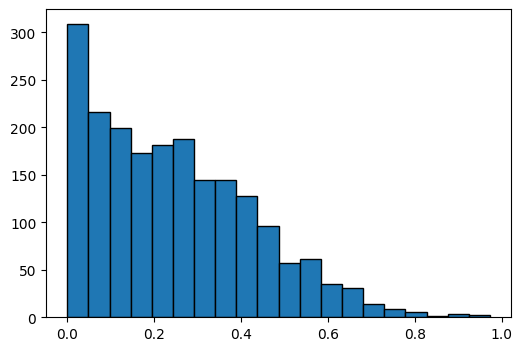

In [34]:
plt.figure(figsize=(6, 4))
plt.hist(list_geobleu_val, bins=20, edgecolor='black')

(array([1.421e+03, 3.730e+02, 1.350e+02, 3.900e+01, 1.200e+01, 9.000e+00,
        6.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.        ,  46.34973861,  92.69947722, 139.04921583,
        185.39895444, 231.74869305, 278.09843167, 324.44817028,
        370.79790889, 417.1476475 , 463.49738611, 509.84712472,
        556.19686333, 602.54660194, 648.89634055, 695.24607916,
        741.59581777, 787.94555639, 834.295295  , 880.64503361,
        926.99477222]),
 <BarContainer object of 20 artists>)

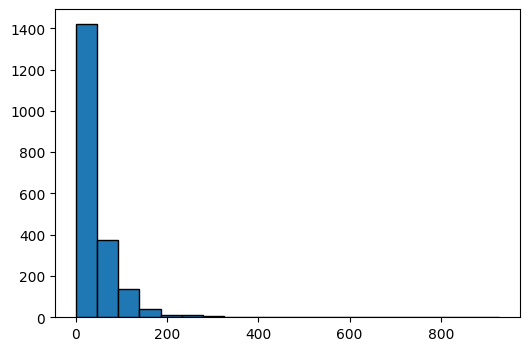

In [35]:
plt.figure(figsize=(6, 4))
plt.hist(list_dtw_val, bins=20, edgecolor='black')

## 可視化して確認

In [57]:
uid =2050

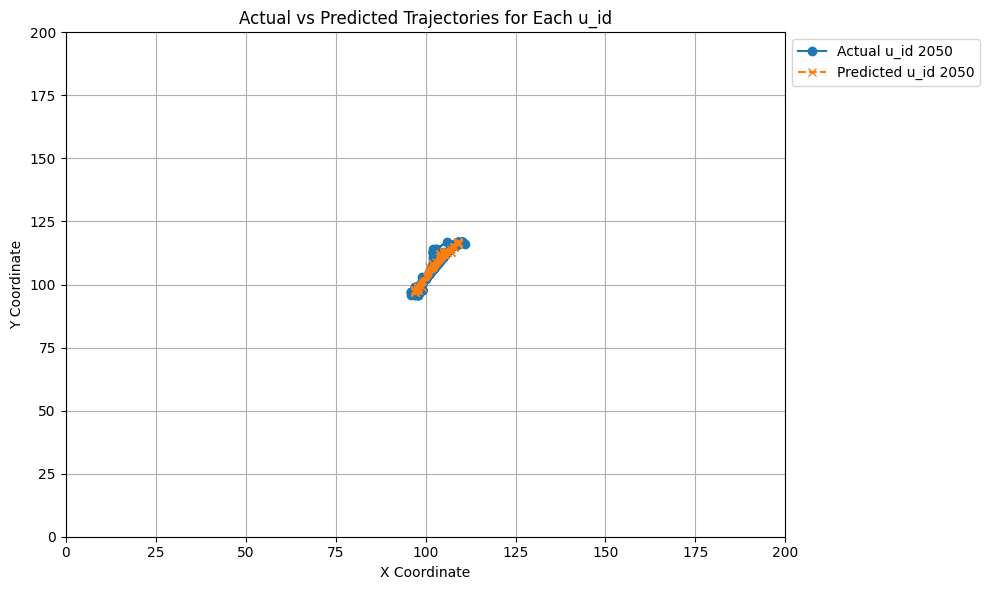

In [58]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 200)  # x軸の範囲を設定
plt.ylim(0, 200)  # y軸の範囲を設定

# プロットを表示
plt.tight_layout()
plt.show()

In [59]:
uid = 2050

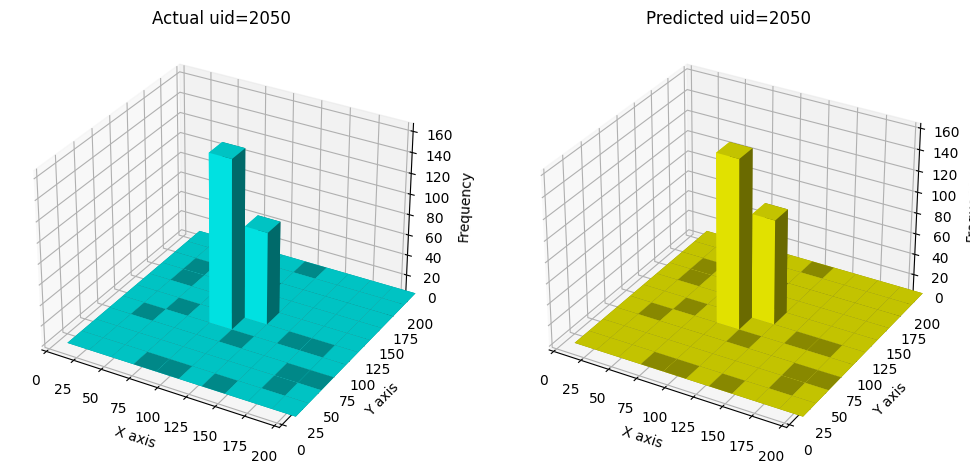

In [60]:
user_data = combined_data[combined_data['uid'] == uid]
# DataFrameからx, yに分割
x1 = user_data['x'].values
y1 = user_data['y'].values
x2 = user_data['x_pred'].values
y2 = user_data['y_pred'].values

# ヒストグラムのビンを設定 (0~200までの範囲に対して適切なビン数)
bins = np.linspace(0, 200, 11)  # 0から200までの範囲で10等分

# 1つ目のデータのヒストグラムを計算
hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=[bins, bins])

# 2つ目のデータのヒストグラムを計算
hist2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=[bins, bins])

# 1つ目の座標の中心点を取得
xpos1, ypos1 = np.meshgrid(xedges1[:-1] + 10, yedges1[:-1] + 10, indexing="ij")
xpos1 = xpos1.ravel()
ypos1 = ypos1.ravel()
zpos1 = np.zeros_like(xpos1)

# 2つ目の座標の中心点を取得
xpos2, ypos2 = np.meshgrid(xedges2[:-1] + 10, yedges2[:-1] + 10, indexing="ij")
xpos2 = xpos2.ravel()
ypos2 = ypos2.ravel()
zpos2 = np.zeros_like(xpos2)

# ビンの幅
dx = dy = 20 * np.ones_like(zpos1)

# 3Dヒストグラムをプロット
fig = plt.figure(figsize=(12, 6))  # 図のサイズを指定

# 1つ目のプロット
ax1 = fig.add_subplot(121, projection='3d')  # 1行2列の1つ目
ax1.bar3d(xpos1, ypos1, zpos1, dx, dy, hist1.ravel(), color='cyan', zsort='average')
ax1.set_title(f'Actual uid={uid}')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Frequency')

ax1.set_xlim([0, 200])
ax1.set_ylim([0, 200])
# ax1.set_zlim([0, 150])  

################

# 2つ目のプロット
ax2 = fig.add_subplot(122, projection='3d')  # 1行2列の2つ目
ax2.bar3d(xpos2, ypos2, zpos2, dx, dy, hist2.ravel(), color='yellow', zsort='average')
ax2.set_title(f'Predicted uid={uid}')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Frequency')

ax2.set_xlim([0, 200])
ax2.set_ylim([0, 200])
# ax2.set_zlim([0, 150])

# プロットを表示
plt.show()

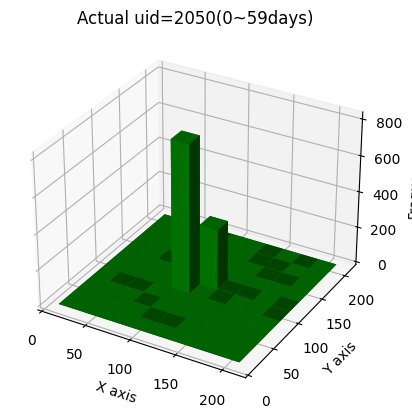

In [61]:
# 0~59日の行動状態も見てみる
user_data = df_city_b_train[df_city_b_train['uid'] == uid]

# DataFrameからx, yに分割
x = user_data['x'].values
y = user_data['y'].values

# ヒストグラムのビンを設定 (0~200までの範囲に対して適切なビン数)
bins = np.linspace(0, 200, 11)  # 0から200までの範囲で10等分

# ヒストグラムを計算
hist, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins])

# 座標の中心点を取得
xpos, ypos = np.meshgrid(xedges[:-1] + 10, yedges[:-1] + 10, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# ビンの幅
dx = dy = 20 * np.ones_like(zpos)
dz = hist.ravel()

# 3Dヒストグラムをプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color='green', zsort='average')
ax.set_title(f'Actual uid={uid}(0~59days)')

# 軸ラベル
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Frequency')

# Show plot
plt.show()
